In [1]:
!pip install nltk pandas numpy scikit-learn numpy wordcloud[speedup]

import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import sys
import nltk
import random
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from textblob import TextBlob

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Mount Google Drive to access the dataset files
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


In [23]:
# Functions needed for the code

# function to remove stop words
def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# function to tokenize and lemmatize text
def clean_review_text(text):
    tokenz = word_tokenize(text)
    tokenz = [lemmatizer.lemmatize(token.lower()) for token in tokenz if token.isalpha() and token.lower() not in stop_words]
    return ' '.join(tokenz)

# define a function to perform sentiment analysis
def get_sentiment(text):
    if isinstance(text, float):  # handle missing or null values
        return 0.0  # set sentiment to 0.0
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [26]:
# load the dataset
merged_df = pd.read_csv('/content/drive/My Drive/combined_final_data.csv')

# replace missing or null values with an empty string
merged_df['amazon_review_body'].fillna('', inplace=True)
merged_df['walmart_review_body'].fillna('', inplace=True)

# apply the sentiment analysis function to the review body column
merged_df['sentiment'] = merged_df['amazon_review_body'].apply(get_sentiment) + merged_df['walmart_review_body'].apply(get_sentiment)

# print the dataframe head
print(merged_df.head(10))

                                       product_title  amazon_star_rating  \
0  The Cravings Place Chocolate Chunk Cookie Mix,...                   5   
1            Mauna Loa Macadamias, 11 Ounce Packages                   5   
2  Organic Matcha Green Tea Powder - 100% Pure Ma...                   5   
3  15oz Raspberry Lyons Designer Dessert Syrup Sauce                   5   
4  Stride Spark Kinetic Fruit Sugar Free Gum, 14-...                   5   
5        Herr's Popcorn Hot Cheese 1 Oz (Pack of 30)                   2   
6              Larabar uber, 1.42 Ounce (Pack of 15)                   5   
7                 Shirakiku Soba Noodles, 7.16 Ounce                   5   
8  Jif Chocolate Nut Butter Almond Granola Bars, ...                   5   
9  Orgain Organic Plant Based Protein Powder, Pac...                   1   

   amazon_total_votes                                 amazon_review_body  \
0                   0  family allergic wheat dairy eggs nuts several ...   
1          

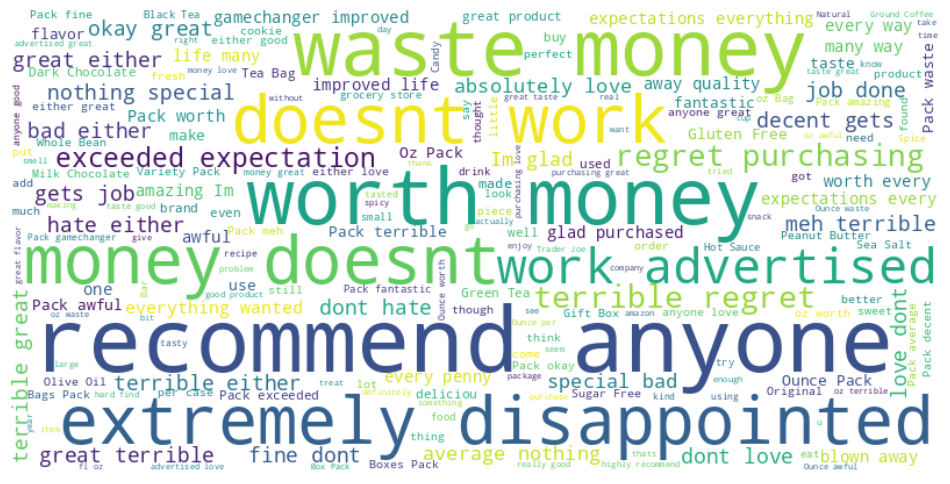

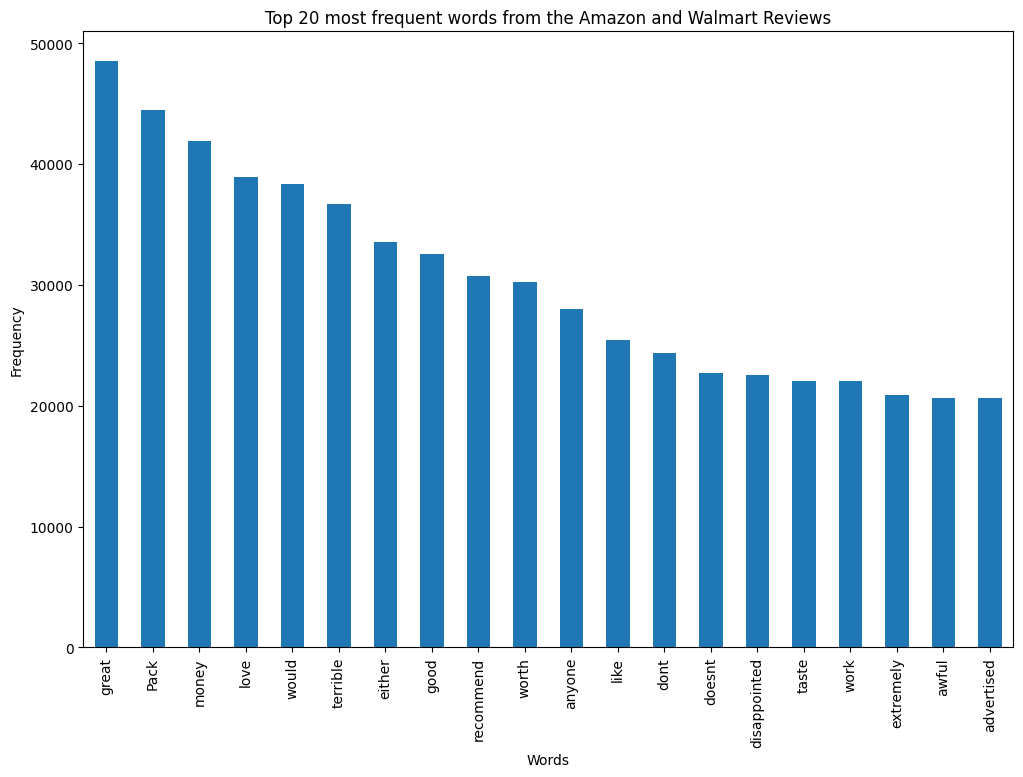

In [30]:
# Merging amazon and walmart reviews into one column and cleaning it of stopwords for further analysis
merged_df['cleaned_review_body'] = merged_df['amazon_review_body'] + ' ' + merged_df['walmart_review_body']

# Define the regular expression pattern to match special characters
pattern = r'[^a-zA-Z0-9\s]'

# Remove special characters from the merged_review_body column
merged_df['cleaned_review_body'] = merged_df['cleaned_review_body'].apply(lambda x: re.sub(pattern, '', x))

# Removing stopwords
merged_df['cleaned_review_body'] = merged_df['cleaned_review_body'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Define the text data
text_data = ' '.join(merged_df['cleaned_review_body'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
print("\n")

# Generate the bar chart
word_counts = pd.Series(text_data.split()).value_counts()[:20]
plt.figure(figsize=(12, 8))
word_counts.plot(kind='bar')
plt.title('Top 20 most frequent words from the Amazon and Walmart Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

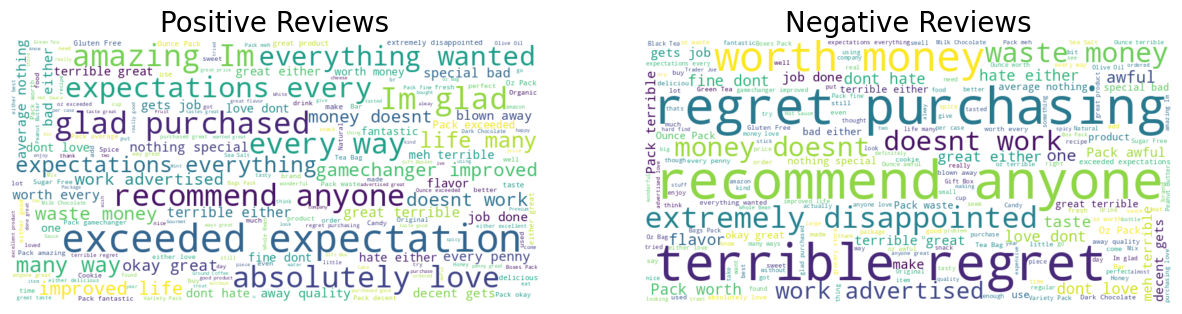

In [34]:
# Wordclouds for positive and negative keywords

# Create separate dataframes for positive and negative reviews
positive_df = merged_df[merged_df['sentiment'] > 0.5]
negative_df = merged_df[merged_df['sentiment'] < 0.5]

# Combine all the reviews into a single string for each dataframe
positive_text = " ".join(review for review in positive_df['cleaned_review_body'])
negative_text = " ".join(review for review in negative_df['cleaned_review_body'])

# Generate wordclouds for positive and negative reviews
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plot the wordclouds
fig, axs = plt.subplots(1, 2, figsize=(15, 7.5))
axs[0].imshow(positive_wordcloud, interpolation='bilinear')
axs[0].set_title('Positive Reviews', fontsize=20)
axs[0].axis('off')
axs[1].imshow(negative_wordcloud, interpolation='bilinear')
axs[1].set_title('Negative Reviews', fontsize=20)
axs[1].axis('off')
plt.show()

Classification Report for Sentiment Analysis:               precision    recall  f1-score   support

           0       0.93      0.97      0.95     43743
           1       0.58      0.34      0.43      5074

    accuracy                           0.91     48817
   macro avg       0.75      0.65      0.69     48817
weighted avg       0.89      0.91      0.89     48817



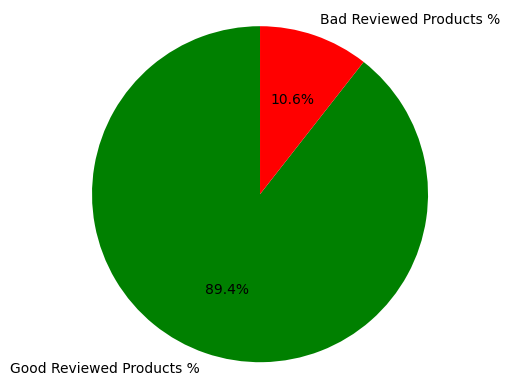

In [47]:
# 1st Method: Bad Review finder using Naive Bayes Classifier ML Model based on star_rating
# Cleaning text
merged_df['cleaned_review_body'] = merged_df['cleaned_review_body'].apply(clean_review_text)

# Generating average_star_rating based on both Amazon and Walmart Ratings
merged_df['star_rating'] = (merged_df['amazon_star_rating'] + merged_df['walmart_star_rating']) / 2

# defining good/bad products based on star_rating
merged_df['is_bad_product'] = merged_df['star_rating'].apply(lambda x: 1 if x < 2.5 else 0)

# vectorize cleaned_review_body
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(merged_df['cleaned_review_body'])
y = merged_df['is_bad_product']

# splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# training Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# prediction on test dataset
y_pred = nb_classifier.predict(X_test)

# Classification report
print("Classification Report for Sentiment Analysis:", classification_report(y_test, y_pred))

good_count = len(merged_df[merged_df['is_bad_product'] == 0])
bad_count = len(merged_df[merged_df['is_bad_product'] == 1])

# Visualize the percentage of Good vs Bad product reviews
labels = ['Good Reviewed Products %', 'Bad Reviewed Products %']
sizes = [good_count, bad_count]
colors = ['green', 'red']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.show()
print("\n")

Percentage of profane reviews: 4.545789751846708%
Percentage of non-profane reviews: 95.45421024815329%


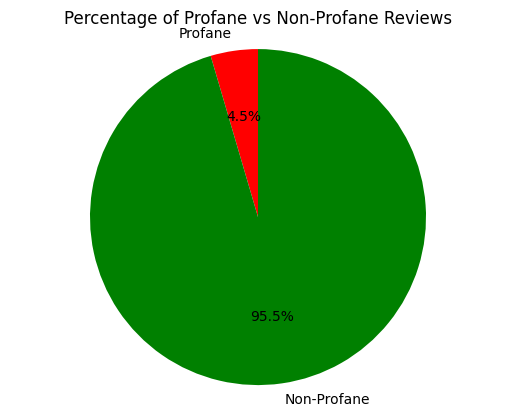

In [45]:
# Profanity Checker
import requests
url = 'https://raw.githubusercontent.com/snguyenthanh/better_profanity/0.7.0/better_profanity/profanity_wordlist.txt'
response = requests.get(url)
profane_words_1 = response.content.decode('utf-8').split('\n')

another_url = 'https://www.cs.cmu.edu/~biglou/resources/bad-words.txt'
response = requests.get(url)
profane_words_2 = response.content.decode('utf-8').split('\n')

# Removing duplicates and merging profanity words data
profane_words = list(set(profane_words_1 + profane_words_2))

# Function to check profanity
def check_profanity(text):
    text_words = text.split()
    profanity_count = 0
    for word in text_words:
        if word.lower() in profane_words:
            profanity_count += 1
    if profanity_count > 0:
        return True
    else:
        return False

# Set threshold for profanity score
threshold = 0.5

# Check for profanity in each review
profanity_scores = []
for review in merged_df['cleaned_review_body']:
    # Split review into individual words
    scores = check_profanity(review)
    # Calculate average profanity score for review
    avg_score = np.mean(scores)
    # Check if average score is above threshold
    if avg_score > threshold:
        profanity_scores.append(1)
    else:
        profanity_scores.append(0)

# Add profanity scores as a new column in the dataframe
merged_df['profanity_score'] = profanity_scores

# Visualize the percentage of profane vs non-profane reviews
profane_count = len(merged_df[merged_df['profanity_score'] == 1])
non_profane_count = len(merged_df[merged_df['profanity_score'] == 0])
print(f"Percentage of profane reviews: {profane_count/len(merged_df)*100}%")
print(f"Percentage of non-profane reviews: {non_profane_count/len(merged_df)*100}%")

labels = ['Profane', 'Non-Profane']
sizes = [profane_count, non_profane_count]
colors = ['red', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Percentage of Profane vs Non-Profane Reviews')
plt.show()